## Cox’s time varying proportional hazard model

Often an individual will have a covariate change over time. An example of this is hospital patients who enter the study and, at some future time, may receive a heart transplant. We would like to know the effect of the transplant, but we must be careful if we condition on whether they received the transplant. Consider that if patients needed to wait at least 1 year before getting a transplant, then everyone who dies before that year is considered as a non-transplant patient, and hence this would overestimate the hazard of not receiving a transplant. 通常，一个人会有一个协变量变化随着时间的推移。 这方面的一个例子是进入研究的医院患者，在未来的某个时候，他们可能会接受心脏移植。 我们想知道移植的效果，但我们必须小心，如果我们条件他们是否接受移植。 考虑一下，如果病人需要等待至少一年才能得到移植，那么在那一年之前死亡的每个人都被认为是非移植病人，因此这将高估不接受移植的危险。

We can incorporate changes over time into our survival analysis by using a modification of the Cox model. The general mathematical description is:

In [8]:
%%html
<img src='Time-Verying Cox.png', width=400, height=300>

Note the time-varying xi(t) to denote that covariates can change over time. This model is implemented in lifelines as CoxTimeVaryingFitter. The dataset schema required is different than previous models, so we will spend some time describing it.

### Dataset creation for time-varying regression

lifelines requires that the dataset be in what is called the long format. This looks like one row per state change, including an ID, the left (exclusive) time point, and right (inclusive) time point. For example, the following dataset tracks three unique subjects.

In [15]:
%%html
<img src='long format.png', width=800, height=600>

In the above dataset, start and stop denote the boundaries, id is the unique identifier per subject, and event denotes if the subject died at the end of that period. For example, subject ID 2 had variable z=0 up to and including the end of time period 5 (we can think that measurements happen at end of the time period), after which it was set to 1. Since event is 1 in that row, we conclude that the subject died at time 8,

This desired dataset can be built up from smaller datasets. To do this we can use some helper functions provided in lifelines. Typically, data will be in a format that looks like it comes out of a relational database. You may have a “base” table with ids, durations alive, and a censored flag, and possibly static covariates. Ex:

In [20]:
%%html
<img src='light format.png', width=400, height=300>

We will perform a light transform to this dataset to modify it into the “long” format.

In [22]:
import pandas as pd
from lifelines.utils import to_long_format

base_df = pd.DataFrame([
  {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
  {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])

base_df = to_long_format(base_df, duration_col="duration")
base_df

,event,id,var1,start,stop
0,True,1,0.1,0,10
1,True,2,0.5,0,12


You’ll also have secondary dataset that references future measurements. This could come in two “types”. The first is when you have a variable that changes over time (ex: administering varying medication over time, or taking a tempature over time). The second types is an event-based dataset: an event happens at some time in the future (ex: an organ transplant occurs, or an intervention). We will address this second type later. The first type of dataset may look something like:

Example:

In [25]:
%%html
<img src='variable changes over time.png', width=200, height=100>

where time is the duration from the entry event. Here we see subject 1 had a change in their var2 covariate at the end of time 4 and at the end of time 8. We can use lifelines.utils.add_covariate_to_timeline() to fold the covariate dataset into the original dataset.

In [27]:
from lifelines.utils import add_covariate_to_timeline

cv = pd.DataFrame([
  {'id': 1, 'time': 0, 'var2': 1.4},
  {'id': 1, 'time': 4, 'var2': 1.2},
  {'id': 1, 'time': 8, 'var2': 1.5},
  {'id': 2, 'time': 0, 'var2': 1.6},

])

df = add_covariate_to_timeline(base_df, cv, duration_col="time", id_col="id", event_col="event")
df

,start,var1,var2,stop,id,event
0,0,0.1,1.4,4.0,1,False
1,4,0.1,1.2,8.0,1,False
2,8,0.1,1.5,10.0,1,True
3,0,0.5,1.6,12.0,2,True


You may have multiple covariates you wish to add, so the above could be streamlined like so:

In [28]:
from lifelines.utils import add_covariate_to_timeline

#向数据中加入多个协变量：cv1，cv2，cv3
df = base_df.pipe(add_covariate_to_timeline, cv1, duration_col="time", id_col="id", event_col="event")\
            .pipe(add_covariate_to_timeline, cv2, duration_col="time", id_col="id", event_col="event")\
            .pipe(add_covariate_to_timeline, cv3, duration_col="time", id_col="id", event_col="event")

NameError: name 'cv1' is not defined

If your dataset is of the second type, that is, event-based, your dataset may look something like the following, where values in the matrix denote times since the subject’s birth, and None or NaN represent the event not happening (subjects can be excluded if the event never occurred as well) :

In [32]:
event_df = pd.DataFrame([
    {'id': 1, 'E1': 1.0},
    {'id': 2, 'E1': None},
    {'id': 3, 'E1': 3.0},
])

print(event_df)
event_df

    E1  id
0  1.0   1
1  NaN   2
2  3.0   3


,E1,id
0,1.0,1
1,NaN,2
2,3.0,3


Initially, this can’t be added to our baseline DataFrame. However, using lifelines.utils.covariates_from_event_matrix() we can convert a DataFrame like this into one that can be easily added.

In [33]:
from lifelines.utils import covariates_from_event_matrix

cv = covariates_from_event_matrix(event_df, id_col="id")
print(cv)

   id  duration  E1
0   1       1.0   1
1   2       inf   1
2   3       3.0   1


In [37]:
base_df = pd.DataFrame([
    {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
    {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])
base_df = to_long_format(base_df, duration_col="duration")
base_df

,event,id,var1,start,stop
0,True,1,0.1,0,10
1,True,2,0.5,0,12


In [39]:
base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="id", event_col="event")
base_df

,start,E1,var1,stop,id,event
0,0.0,NaN,0.1,1.0,1,False
1,1.0,1.0,0.1,10.0,1,True
2,0.0,NaN,0.5,12.0,2,True


### Cumulative sums

One additional flag on add_covariate_to_timeline() that is of interest is the cumulative_sum flag. By default it is False, but turning it to True will perform a cumulative sum on the covariate before joining. This is useful if the covariates describe an incremental change, instead of a state update. For example, we may have measurements of drugs administered to a patient, and we want the covariate to reflect how much we have administered since the start. Event columns do make sense to cumulative sum as well. In contrast, a covariate to measure the temperature of the patient is a state update, and should not be summed. See Example cumulative sums over time-varying covariates to see an example of this.                                                       add_covariate_to_timeline()上另一个感兴趣的标志是cumulative_sum标志。 默认情况下，它是假的，但将其变为true将在加入之前对协变量执行累积和。 如果协变量描述增量变化，而不是状态更新，这是有用的。 例如，我们可能有给病人服用药物的测量，我们希望协变量反映我们自开始以来给药的数量。 事件列对累积和也有意义。 相反，测量病人温度的协变量是状态更新，不应求和。 请参阅时变协变量上的示例累积和，以查看此示例。

### Delaying time-varying covariates

add_covariate_to_timeline() also has an option for delaying, or shifting, a covariate so it changes later than originally observed. One may ask, why should one delay a time-varying covariate? Here’s an example. Consider investigating the impact of smoking on mortality and available to us are time-varying observations of how many cigarettes are consumed each month. Unbeknownst to us, when a subject reaches critical illness levels, they are admitted to the hospital and their cigarette consumption drops to zero. Some expire while in hospital. If we used this dataset naively, we would see that not smoking leads to sudden death, and conversely, smoking helps your health! This is a case of reverse causation: the upcoming death event actually influences the covariates. add_covariate_to_timeline()也有一个选择，延迟或移动，协变量，所以它的变化比最初观察到的晚。 人们可能会问，为什么一个应该延迟一个时变的协变量？ 这是一个例子。 考虑调查吸烟对死亡率的影响，我们可以得到的是每月消费多少支香烟的时变观察。 我们不知道，当一个受试者达到危重疾病水平时，他们被送进医院，他们的香烟消费量下降到零。 有些在医院里过期了。 如果我们天真地使用这个数据集，我们会看到不吸烟会导致猝死，相反，吸烟会帮助你的健康！ 这是一个反向因果关系的情况：即将到来的死亡事件实际上影响协变量。

To handle this, you can delay the observations by time periods. This has the possible of effect of dropping rows outside the observation window. 要处理这一点，您可以按时间段延迟观察。 这可能会导致观察窗口外的行丢失。

In [41]:
from lifelines.utils import add_covariate_to_timeline

cv = pd.DataFrame([
    {'id': 1, 'time': 0, 'var2': 1.4},
    {'id': 1, 'time': 4, 'var2': 1.2},
    {'id': 1, 'time': 8, 'var2': 1.5},
    {'id': 2, 'time': 0, 'var2': 1.6},
])

base_df = pd.DataFrame([
    {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
    {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])
base_df = to_long_format(base_df, duration_col="duration")

base_df = add_covariate_to_timeline(base_df, cv, duration_col="time", id_col="id", event_col="event", delay=5)\
            .fillna(0)

print(base_df)

   start  var1  var2  stop  id  event
0      0   0.1   0.0   5.0   1  False
1      5   0.1   1.4   9.0   1  False
2      9   0.1   1.2  10.0   1   True
3      0   0.5   0.0   5.0   2  False
4      5   0.5   1.6  12.0   2   True


## Fitting the model

Once your dataset is in the correct orientation, we can use CoxTimeVaryingFitter to fit the model to your data. The method is similar to CoxPHFitter, except we need to tell the fit() about the additional time columns.

Fitting the Cox model to the data involves an iterative gradient descent. lifelines takes extra effort to help with convergence, so please be attentive to any warnings that appear. Fixing any warnings will generally help convergence. For further help, see Problems with convergence in the Cox proportional hazard model.

Iteration 4: norm_delta = 0.00040, step_size = 1.00000, ll = -0.35664, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 4 iterations.


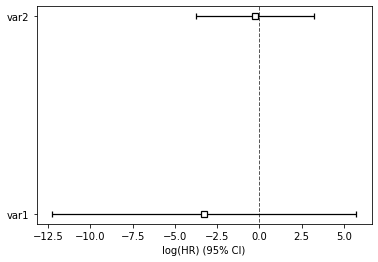

In [42]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(base_df, id_col="id", event_col="event", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()
ctv.plot()

### Short note on prediction

Unlike the other regression models, prediction in a time-varying setting is not trivial. To predict, we would need to know the covariates values beyond the observed times, but if we knew that, we would also know if the subject was still alive or not! However, it is still possible to compute the hazard values of subjects at known observations, the baseline cumulative hazard rate, and baseline survival function. So while CoxTimeVaryingFitter exposes prediction methods, there are logical limitations to what these predictions mean.  与其他回归模型不同，时变环境下的预测并不是微不足道的。 要预测，我们需要知道观察时间以外的协变量值，但如果我们知道，我们也会知道受试者是否还活着！ 然而，在已知观测值、基线累积危险率和基线生存函数下，仍然可以计算受试者的危险值。 因此，虽然Coxtimentifitter公开了预测方法，但这些预测的含义有逻辑上的局限性。

In [43]:
ctv.predict_cumulative_hazard(base_df)

AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'predict_cumulative_hazard'

In [44]:
ctv.predict_log_partial_hazard(base_df)

0    0.739761
1    0.378482
2    0.430093
3   -0.567723
4   -0.980613
dtype: float64